### Importing the needed libraries for web scraping

In [39]:
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.common.keys import Keys

import time
import re


**Setting up a dictionary to hold the links used in the scraping**
    1. [Sales in U.S.](#https://carsalesbase.com/car-sales-us-home-main/)         2. [Sales in Europe](#https://carsalesbase.com/car-sales-europe-home-main/)

In [40]:
urls = {
	'url_1': 'https://carsalesbase.com/car-sales-us-home-main/',
	'url_2': 'https://carsalesbase.com/car-sales-europe-home-main/',
}

**Defining the function** *retrieve_car_sales_data* **that will scrape all all the information from the website**
The function goes through 60 links, which represent car brands, and retrieves the monthly and annual sales information. It then returns those data via a
dictionary

In [50]:
def retrieve_car_sales_data_1(region):
	opts = Options()
	opts.set_headless = True
	driver = webdriver.Firefox(options=opts)
	if region == 'U.S.':
		driver.get(urls['url_1'])
	else:
		driver.get(urls['url_2'])

	# brand_photos has 60 elements
	# dictionary of dictionaries: key = brand name, value = sales_per_year
	car_sales = {
	}

	# traversing the links for 30 car brands available on the website's home page
	for i in range(0, 60):
		# skipping Daewoo and Daihatsu
		if (region == 'U.S.') or region == 'Europe':
			# get the car brand name
			brand_names = WebDriverWait(driver, 10).until(
				EC.presence_of_all_elements_located((By.XPATH, "//div[@id='block-wrap-13046']/div[@class='tipi-row-inner-style clearfix']/div[@class='tipi-row-inner-box contents fs-contents']/div[@class='block block-83 clearfix tipi-flex ']/article/div[@class='meta']/div[@class='title-wrap']/h3[@class='title']/a"))
			)
			
			# brand_names = driver.find_elements_by_xpath("//div[@id='block-wrap-13046']/div[@class='tipi-row-inner-style clearfix']/div[@class='tipi-row-inner-box contents fs-contents']/div[@class='block block-83 clearfix tipi-flex ']/article/div[@class='meta']/div[@class='title-wrap']/h3[@class='title']/a") # /div[@class='title_wrap']/h3[@class='title']")
			brand_name = brand_names[i].get_attribute('innerHTML')
			if region == 'U.S.':
				brand_name = brand_name.split(" U.S") 
			else:
				brand_name = brand_name.split(" Europe")
			brand_name = brand_name[0]
			# print(brand_name)

			if (region == 'U.S.') or (region == 'Europe' and (brand_name == 'Cadillac' or brand_name == 'Chevrolet' or brand_name == 'Crystler' or brand_name == 'Dodge' or brand_name == 'Ford' or brand_name == 'Hummer' or brand_name == 'Jeep')):

				# get the list of cars
				
				brand_photos = WebDriverWait(driver, 10).until(
					EC.presence_of_all_elements_located((By.XPATH, "//div[@id='block-wrap-13046']/div[@class='tipi-row-inner-style clearfix']/div[@class='tipi-row-inner-box contents fs-contents']/div[@class='block block-83 clearfix tipi-flex ']/article/div[@class='mask']/a"))
				)

				# click on a car brand
				driver.execute_script("arguments[0].click();", brand_photos[2*i])

				# time.sleep(5)

				###############################################################################
				# start ---			Getting Monthly Sales
				try:
					monthly_sales = WebDriverWait(driver, 10).until(
						EC.presence_of_all_elements_located((By.XPATH, "//div[@class='wpDataTables wpDataTablesWrapper']/div[@class='wdtscroll']/table[@class='scroll responsive display nowrap data-t data-t wpDataTable dataTable']/tbody/tr/td"))
					)
					# monthly_sales = driver.find_elements_by_xpath("//div[@class='wpDataTables wpDataTablesWrapper']/div[@class='wdtscroll']/table[@class='scroll responsive display nowrap data-t data-t wpDataTable dataTable']/tbody/tr/td")
						# else:
					# check whether the monthly sales table exists for the current car brand
					if len(monthly_sales) != 0:
					# dictionary of arrays: key = year, value = array of monthly sales
						sales_per_year = {}
						sales = []

						# Aston Martin, does not have the monthly_sales table, so we should skip it
						num_of_months = 12
						current_month = 0
						year = 0

						# traverse the columns in a Monthly Sales table
						for monthly_sale in monthly_sales:
							if current_month == 0:
								year = monthly_sale.text
							else:
								sale = monthly_sale.text

							
								sales.append(sale)

							if current_month ==  num_of_months:
								current_month = 0
								sales_per_year[year] = sales
								sales = []
								
							else:
								current_month += 1
					
						# print(sales_per_year)

						# update the monthly sales for the current car 
						car_sales[brand_name] = sales_per_year
					else:
						aa = 0
				except:
					aa = 0
				# end --- 			Getting Monthly Sales
				###############################################################################


				###############################################################################
				# start ---			Getting Annual Sales
				



				annual_sales = WebDriverWait(driver, 10).until(
					EC.presence_of_all_elements_located((By.XPATH, "//div[@class='wpDataTables wpDataTablesWrapper no-footer']/table[@class='responsive display nowrap data-t data-t wpDataTable dataTable no-footer']/tbody/tr/td"))
				)

				# annual_sales = driver.find_elements_by_xpath("//div[@class='wpDataTables wpDataTablesWrapper no-footer']/table[@class='responsive display nowrap data-t data-t wpDataTable dataTable no-footer']/tbody/tr/td")
				# dictionary of arrays. key = brand name, value = sales_per_year
				annual_sales_dict = {}
				# dictionary of arrays. key = year, value = array of sales, growth, market share
				sales_per_year = {}

				# setting up remainder constants for the Year, Sales, Growth, and Market Share
				YEAR = 0
				SALES = 1
				GROWTH = 2
				MARKET_SHARE = 3


				if len(annual_sales) != 0:
					year = 0
					# row in the annual sales table
					sales_growth_array = []
					counter = 0
					for annual_sale in annual_sales:
						if counter % 4 == YEAR:
							year = annual_sale.text
							# reset the row
							sales_growth_array = []
						else:
							sales_growth_array.append(annual_sale.text)
							

						if counter % 4 == MARKET_SHARE:
							sales_per_year[year] = sales_growth_array
						
						counter += 1
					annual_sales_dict[brand_name] = sales_per_year

				driver.back()

			if i >= 29:
				load_more_button = WebDriverWait(driver, 10).until(
					EC.presence_of_all_elements_located((By.XPATH, "//div[@class='tipi-row-inner-box contents fs-contents']/div[@class='load-more-wrap load-more-size-2 load-more-wrap-1']/span[@data-id='13046']"))
				)
				# load_more_button = driver.find_elements_by_xpath("//div[@class='tipi-row-inner-box contents fs-contents']/div[@class='load-more-wrap load-more-size-2 load-more-wrap-1']/span[@data-id='13046']")
				# click on Load More button
				driver.execute_script("arguments[0].click();", load_more_button[0])

				# time.sleep(5)
		
			brand_photos = WebDriverWait(driver, 10).until(
					EC.presence_of_all_elements_located((By.XPATH, "//div[@id='block-wrap-13046']/div[@class='tipi-row-inner-style clearfix']/div[@class='tipi-row-inner-box contents fs-contents']/div[@class='block block-83 clearfix tipi-flex ']/article/div[@class='mask']/a"))
			)

			
			# brand_photos = driver.find_elements_by_xpath("//div[@id='block-wrap-13046']/div[@class='tipi-row-inner-style clearfix']/div[@class='tipi-row-inner-box contents fs-contents']/div[@class='block block-83 clearfix tipi-flex ']/article/div[@class='mask']/a")

			# end --- 			Getting Annual Sales
			###############################################################################

	return_dict = {}
	return_dict['monthly_sales'] = car_sales
	return_dict['annual_sales'] = annual_sales_dict

	return return_dict

### Below is a list of all the car brands scrapped by the function
   ##### Acura
   ##### Alfa Romeo
   ##### Aston Martin		
   ##### Audi
   ##### Bentley
   ##### BMW
   ##### Buick
   ##### Cadillac
   ##### Chevrolet
   ##### Chrysler
   ##### Daewoo			
   ##### Daihatsu		
   ##### Dodge
   ##### Ferarri			
   ##### Fiat
   ##### Ford
   ##### Genesis
   ##### GMC
   ##### Honda
   ##### Hummer			
   ##### Hundai
   ##### Infiniti
   ##### Isuzu			
   ##### Jaguar
   ##### Jeep
   ##### Kia
   ##### Lamborghini
   ##### Lancia			
   ##### Land Rover
   ##### Lexus

### The function returns a dictionary, which is the combined version of the monthly sales. 
**retrieve those sales data, and split them into monthly and annual sales.**

In [51]:
overall_sales = retrieve_car_sales_data_1('U.S.')

Separate the monthly sales from annual sales

In [52]:
monthly_sales = overall_sales['monthly_sales']
annual_sales = overall_sales['annual_sales']

**Print the retrieved data for monthly sales.**
The key of the dictionary is the brand name, and the value is
itself a dictionary, containing monthly sales for each year, starting from 2016
Note: some brands miss data points. For example, *Alfa Romeo* does not have the whole data for 2019.

In [53]:
print(monthly_sales)

{'Alfa Romeo': {'2016': ['67', '47', '53', '60', '44', '36', '43', '37', '41', '23', '23', '52'], '2017': ['108', '443', '555', '677', '919', '1,017', '1,225', '1,140', '1,268', '1,205', '1,440', '2,034'], '2018': ['1,648', '1,568', '2,576', '1,847', '2,377', '2,249', '2,016', '2,240', '1,639', '1,737', '1,957', '1,946'], '2019': ['1,150', '1,362', '1,774', '1,584', '1,572', '1,595', '', '', '4,310', '', '', '4,945'], '2020': ['', '', '3,703', '', '', '3,734', '', '', '5,056', '', '', '']}, 'Audi': {'2016': ['11,850', '11,718', '18,392', '17,801', '18,728', '18,445', '18,364', '19,264', '17,617', '17,721', '17,118', '23,195'], '2017': ['13,201', '13,741', '18,705', '18,711', '19,197', '19,416', '18,824', '19,811', '19,308', '19,425', '19,195', '26,977'], '2018': ['14,511', '15,451', '20,090', '19,104', '19,315', '19,471', '19,221', '20,907', '19,350', '16,056', '17,082', '22,765'], '2019': ['14,253', '13,560', '20,302', '15,024', '18,892', '19,409', '19,370', '21,531', '16,130', '19,17

Import statistics and pylab libraries to do analysis

In [56]:
import statistics
import pylab as plt

Traverse through the monthly sales data
If the z-score of the company - the October's monthly sale is >= 1 standard deviation to the right from the monthly mean, then the company is doing well, and we should invest in that company.

******************************
Alfa Romeo
----------------------------------
2016: ['67', '47', '53', '60', '44', '36', '43', '37', '41', '23', '23', '52']
monthly_mean: 43.833
['67', '47', '53', '60', '44', '36', '43', '37', '41', '23', '23', '52']
[67, 47, 53, 60, 44, 36, 43, 37, 41, 23, 23, 52]
standard deviation: 13.292741240879161
----------------------------------
2017: ['108', '443', '555', '677', '919', '1,017', '1,225', '1,140', '1,268', '1,205', '1,440', '2,034']
monthly_mean: 1002.583
['108', '443', '555', '677', '919', '1,017', '1,225', '1,140', '1,268', '1,205', '1,440', '2,034']
[108, 443, 555, 677, 919, 1017, 1225, 1140, 1268, 1205, 1440, 2034]
standard deviation: 510.0683480642273
----------------------------------
2018: ['1,648', '1,568', '2,576', '1,847', '2,377', '2,249', '2,016', '2,240', '1,639', '1,737', '1,957', '1,946']
monthly_mean: 1983.333
['1,648', '1,568', '2,576', '1,847', '2,377', '2,249', '2,016', '2,240', '1,639', '1,737', '1,957', '1,946']
[1648, 1568,

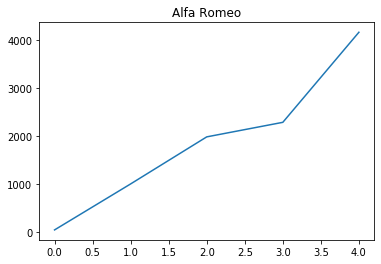

******************************
Audi
----------------------------------
2016: ['11,850', '11,718', '18,392', '17,801', '18,728', '18,445', '18,364', '19,264', '17,617', '17,721', '17,118', '23,195']
monthly_mean: 17517.75
['11,850', '11,718', '18,392', '17,801', '18,728', '18,445', '18,364', '19,264', '17,617', '17,721', '17,118', '23,195']
[11850, 11718, 18392, 17801, 18728, 18445, 18364, 19264, 17617, 17721, 17118, 23195]
standard deviation: 3091.5895918678234
----------------------------------
2017: ['13,201', '13,741', '18,705', '18,711', '19,197', '19,416', '18,824', '19,811', '19,308', '19,425', '19,195', '26,977']
monthly_mean: 18875.917
['13,201', '13,741', '18,705', '18,711', '19,197', '19,416', '18,824', '19,811', '19,308', '19,425', '19,195', '26,977']
[13201, 13741, 18705, 18711, 19197, 19416, 18824, 19811, 19308, 19425, 19195, 26977]
standard deviation: 3386.039157222259
----------------------------------
2018: ['14,511', '15,451', '20,090', '19,104', '19,315', '19,471', '1

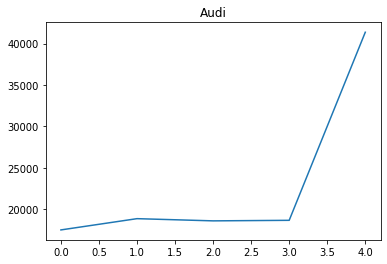

******************************
Bentley
----------------------------------
2016: ['81', '62', '119', '110', '112', '144', '165', '399', '283', '312', '387', '407']
monthly_mean: 215.083
['81', '62', '119', '110', '112', '144', '165', '399', '283', '312', '387', '407']
[81, 62, 119, 110, 112, 144, 165, 399, 283, 312, 387, 407]
standard deviation: 132.8337705783458
----------------------------------
2017: ['148', '155', '249', '168', '210', '218', '155', '213', '156', '', '247', '298']
monthly_mean: 201.545
['148', '155', '249', '168', '210', '218', '155', '213', '156', '', '247', '298']
[148, 155, 249, 168, 210, 218, 155, 213, 156, 247, 298]
standard deviation: 49.492148137585694
----------------------------------
2018: ['210', '204', '232', '165', '165', '', '', '', '', '', '', '']
monthly_mean: 195.2
['210', '204', '232', '165', '165', '', '', '', '', '', '', '']
[210, 204, 232, 165, 165]
standard deviation: 29.473717105244802
----------------------------------
2019: ['', '', '', '', '

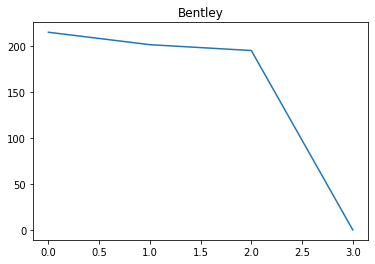

******************************
BMW
----------------------------------
2016: ['18,082', '22,498', '30,033', '24,951', '29,017', '28,855', '25,777', '25,531', '25,389', '24,017', '26,189', '32,835']
monthly_mean: 26097.833
['18,082', '22,498', '30,033', '24,951', '29,017', '28,855', '25,777', '25,531', '25,389', '24,017', '26,189', '32,835']
[18082, 22498, 30033, 24951, 29017, 28855, 25777, 25531, 25389, 24017, 26189, 32835]
standard deviation: 3823.265164117121
----------------------------------
2017: ['18,109', '22,558', '31,015', '22,624', '25,818', '28,962', '21,965', '23,553', '25,571', '23,208', '28,049', '34,253']
monthly_mean: 25473.75
['18,109', '22,558', '31,015', '22,624', '25,818', '28,962', '21,965', '23,553', '25,571', '23,208', '28,049', '34,253']
[18109, 22558, 31015, 22624, 25818, 28962, 21965, 23553, 25571, 23208, 28049, 34253]
standard deviation: 4458.953141000291
----------------------------------
2018: ['19,016', '23,508', '31,311', '23,482', '26,662', '29,407', '21,

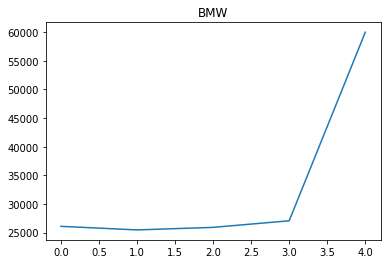

******************************
Buick
----------------------------------
2016: ['18,269', '17,811', '18,207', '17,720', '15,625', '16,575', '22,960', '21,678', '20,922', '20,046', '18,530', '21,288']
monthly_mean: 19135.917
['18,269', '17,811', '18,207', '17,720', '15,625', '16,575', '22,960', '21,678', '20,922', '20,046', '18,530', '21,288']
[18269, 17811, 18207, 17720, 15625, 16575, 22960, 21678, 20922, 20046, 18530, 21288]
standard deviation: 2223.0656334454143
----------------------------------
2017: ['13,117', '16,131', '20,957', '20,735', '20,077', '19,299', '15,966', '16,811', '16,737', '19,142', '17,974', '22,285']
monthly_mean: 18269.25
['13,117', '16,131', '20,957', '20,735', '20,077', '19,299', '15,966', '16,811', '16,737', '19,142', '17,974', '22,285']
[13117, 16131, 20957, 20735, 20077, 19299, 15966, 16811, 16737, 19142, 17974, 22285]
standard deviation: 2619.93091945709
----------------------------------
2018: ['13,348', '16,322', '26,834', '', '', '17,485', '', '', '45,91

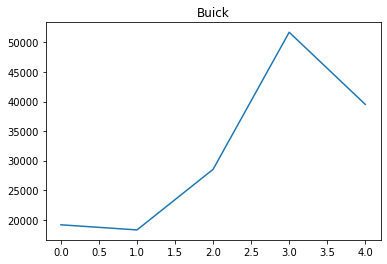

******************************
Cadillac
----------------------------------
2016: ['10,740', '11,840', '13,053', '11,236', '12,099', '14,263', '14,341', '16,346', '15,368', '13,948', '15,326', '21,446']
monthly_mean: 14167.167
['10,740', '11,840', '13,053', '11,236', '12,099', '14,263', '14,341', '16,346', '15,368', '13,948', '15,326', '21,446']
[10740, 11840, 13053, 11236, 12099, 14263, 14341, 16346, 15368, 13948, 15326, 21446]
standard deviation: 2889.993011420721
----------------------------------
2017: ['10,298', '10,823', '12,861', '12,300', '13,211', '12,580', '11,227', '15,016', '15,530', '13,931', '13,359', '15,304']
monthly_mean: 13036.667
['10,298', '10,823', '12,861', '12,300', '13,211', '12,580', '11,227', '15,016', '15,530', '13,931', '13,359', '15,304']
[10298, 10823, 12861, 12300, 13211, 12580, 11227, 15016, 15530, 13931, 13359, 15304]
standard deviation: 1723.2892614961306
----------------------------------
2018: ['9,895', '12,338', '14,494', '13,329', '14,763', '12,757'

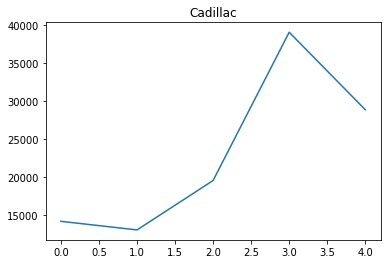

******************************
Chevrolet
----------------------------------
2016: ['137,803', '158,644', '176,283', '183,442', '169,331', '181,387', '178,820', '175,965', '170,237', '181,964', '169,675', '212,959']
monthly_mean: 174709.167
['137,803', '158,644', '176,283', '183,442', '169,331', '181,387', '178,820', '175,965', '170,237', '181,964', '169,675', '212,959']
[137803, 158644, 176283, 183442, 169331, 181387, 178820, 175965, 170237, 181964, 169675, 212959]
standard deviation: 17456.21461534458
----------------------------------
2017: ['135,170', '164,095', '172,458', '164,367', '162,950', '169,838', '151,502', '196,007', '199,801', '175,110', '167,777', '206,804']
monthly_mean: 172156.583
['135,170', '164,095', '172,458', '164,367', '162,950', '169,838', '151,502', '196,007', '199,801', '175,110', '167,777', '206,804']
[135170, 164095, 172458, 164367, 162950, 169838, 151502, 196007, 199801, 175110, 167777, 206804]
standard deviation: 20386.976236885483
------------------------

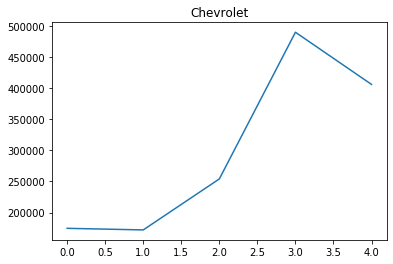

******************************
Chrysler
----------------------------------
2016: ['18,214', '21,056', '26,236', '22,843', '24,276', '24,747', '19,095', '18,753', '18,797', '14,181', '14,518', '16,776']
monthly_mean: 19957.667
['18,214', '21,056', '26,236', '22,843', '24,276', '24,747', '19,095', '18,753', '18,797', '14,181', '14,518', '16,776']
[18214, 21056, 26236, 22843, 24276, 24747, 19095, 18753, 18797, 14181, 14518, 16776]
standard deviation: 3933.544095534605
----------------------------------
2017: ['13,377', '16,730', '16,969', '17,309', '17,969', '19,741', '13,303', '12,652', '15,759', '11,018', '16,510', '17,208']
monthly_mean: 15712.083
['13,377', '16,730', '16,969', '17,309', '17,969', '19,741', '13,303', '12,652', '15,759', '11,018', '16,510', '17,208']
[13377, 16730, 16969, 17309, 17969, 19741, 13303, 12652, 15759, 11018, 16510, 17208]
standard deviation: 2558.8250662554033
----------------------------------
2018: ['10,584', '16,150', '19,499', '14,189', '14,724', '13,484

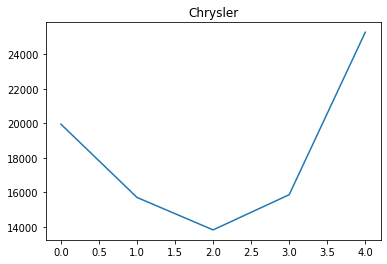

******************************
Dodge
----------------------------------
2016: ['42,109', '47,251', '51,159', '43,575', '42,837', '44,819', '35,520', '44,340', '42,935', '41,514', '34,075', '36,329']
monthly_mean: 42205.25
['42,109', '47,251', '51,159', '43,575', '42,837', '44,819', '35,520', '44,340', '42,935', '41,514', '34,075', '36,329']
[42109, 47251, 51159, 43575, 42837, 44819, 35520, 44340, 42935, 41514, 34075, 36329]
standard deviation: 4914.143541859557
----------------------------------
2017: ['40,109', '43,878', '50,076', '39,445', '44,922', '42,550', '31,264', '43,608', '29,938', '24,476', '28,845', '27,883']
monthly_mean: 37249.5
['40,109', '43,878', '50,076', '39,445', '44,922', '42,550', '31,264', '43,608', '29,938', '24,476', '28,845', '27,883']
[40109, 43878, 50076, 39445, 44922, 42550, 31264, 43608, 29938, 24476, 28845, 27883]
standard deviation: 8310.232690101786
----------------------------------
2018: ['27,600', '40,187', '49,184', '40,994', '46,581', '46,387', '31,

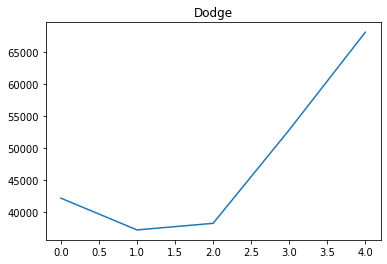

******************************
Fiat
----------------------------------
2016: ['2,594', '2,993', '3,422', '3,045', '3,137', '2,544', '2,754', '2,732', '2,319', '2,622', '2,415', '2,606']
monthly_mean: 2765.25
['2,594', '2,993', '3,422', '3,045', '3,137', '2,544', '2,754', '2,732', '2,319', '2,622', '2,415', '2,606']
[2594, 2993, 3422, 3045, 3137, 2544, 2754, 2732, 2319, 2622, 2415, 2606]
standard deviation: 322.89236174416897
----------------------------------
2017: ['2,164', '2,145', '2,922', '2,539', '2,670', '2,242', '2,244', '2,120', '2,206', '1,769', '1,733', '1,738']
monthly_mean: 2207.667
['2,164', '2,145', '2,922', '2,539', '2,670', '2,242', '2,244', '2,120', '2,206', '1,769', '1,733', '1,738']
[2164, 2145, 2922, 2539, 2670, 2242, 2244, 2120, 2206, 1769, 1733, 1738]
standard deviation: 367.81302891880307
----------------------------------
2018: ['1,229', '1,241', '1,544', '1,404', '1,441', '1,426', '1,240', '1,374', '1,185', '1,151', '1,309', '977']
monthly_mean: 1293.417
['1,22

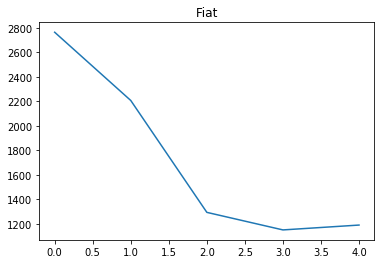

******************************
Ford
----------------------------------
2016: ['165,301', '280,006', '243,375', '219,963', '224,941', '230,287', '20,617', '204,168', '194,647', '178,623', '187,012', '224,994']
monthly_mean: 197827.833
['165,301', '280,006', '243,375', '219,963', '224,941', '230,287', '20,617', '204,168', '194,647', '178,623', '187,012', '224,994']
[165301, 280006, 243375, 219963, 224941, 230287, 20617, 204168, 194647, 178623, 187012, 224994]
standard deviation: 63848.03023634015
----------------------------------
2017: ['162,401', '198,720', '225,341', '203,745', '229,962', '217,891', '190,443', '200,321', '212,841', '190,789', '201,296', '230,291']
monthly_mean: 205336.75
['162,401', '198,720', '225,341', '203,745', '229,962', '217,891', '190,443', '200,321', '212,841', '190,789', '201,296', '230,291']
[162401, 198720, 225341, 203745, 229962, 217891, 190443, 200321, 212841, 190789, 201296, 230291]
standard deviation: 19558.654011715633
---------------------------------

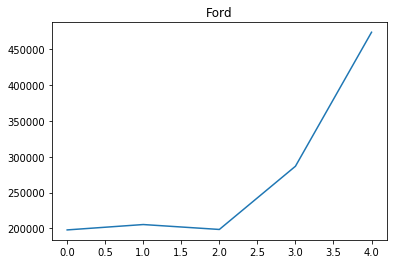

******************************
Genesis
----------------------------------
2016: ['', '', '', '', '', '', '', '1,497', '1,210', '1,201', '1,306', '1,733']
monthly_mean: 1389.4
['', '', '', '', '', '', '', '1,497', '1,210', '1,201', '1,306', '1,733']
[1497, 1210, 1201, 1306, 1733]
standard deviation: 225.9829639596755
----------------------------------
2017: ['1,818', '1,582', '1,755', '1,399', '1,752', '1,613', '1,644', '1,803', '1,736', '1,786', '1,776', '1,948']
monthly_mean: 1717.667
['1,818', '1,582', '1,755', '1,399', '1,752', '1,613', '1,644', '1,803', '1,736', '1,786', '1,776', '1,948']
[1818, 1582, 1755, 1399, 1752, 1613, 1644, 1803, 1736, 1786, 1776, 1948]
standard deviation: 140.68619712184298
----------------------------------
2018: ['1,613', '1,363', '1,386', '1,028', '1,076', '796', '615', '613', '419', '372', '417', '614']
monthly_mean: 859.333
['1,613', '1,363', '1,386', '1,028', '1,076', '796', '615', '613', '419', '372', '417', '614']
[1613, 1363, 1386, 1028, 1076, 796,

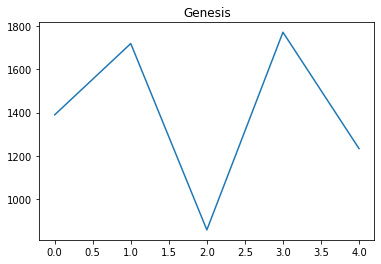

******************************
GMC
----------------------------------
2016: ['36,933', '39,530', '44,585', '47,159', '43,395', '42,985', '51,137', '42,440', '43,268', '42,668', '49,113', '63,415']
monthly_mean: 45552.333
['36,933', '39,530', '44,585', '47,159', '43,395', '42,985', '51,137', '42,440', '43,268', '42,668', '49,113', '63,415']
[36933, 39530, 44585, 47159, 43395, 42985, 51137, 42440, 43268, 42668, 49113, 63415]
standard deviation: 6819.022128419792
----------------------------------
2017: ['37,324', '46,339', '49,948', '47,004', '41,126', '41,434', '47,412', '47,718', '47,329', '44,630', '46,277', '64,146']
monthly_mean: 46723.917
['37,324', '46,339', '49,948', '47,004', '41,126', '41,434', '47,412', '47,718', '47,329', '44,630', '46,277', '64,146']
[37324, 46339, 49948, 47004, 41126, 41434, 47412, 47718, 47329, 44630, 46277, 64146]
standard deviation: 6524.364398974513
----------------------------------
2018: ['33,058', '42,640', '55,646', '42,699', '47,336', '48,420', '',

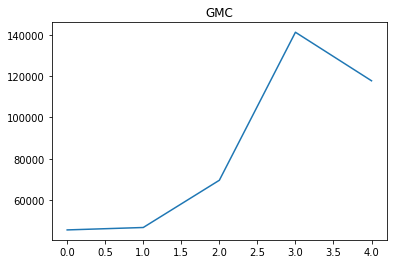

******************************
Honda
----------------------------------
2016: ['90,247', '106,213', '123,369', '132,623', '133,547', '127,363', '139,125', '135,325', '120,842', '113,292', '111,308', '143,329']
monthly_mean: 123048.583
['90,247', '106,213', '123,369', '132,623', '133,547', '127,363', '139,125', '135,325', '120,842', '113,292', '111,308', '143,329']
[90247, 106213, 123369, 132623, 133547, 127363, 139125, 135325, 120842, 113292, 111308, 143329]
standard deviation: 15487.067639915998
----------------------------------
2017: ['97,178', '110,822', '125,531', '124,254', '134,475', '125,755', '136,803', '132,883', '129,776', '114,655', '120,440', '134,255']
monthly_mean: 123902.25
['97,178', '110,822', '125,531', '124,254', '134,475', '125,755', '136,803', '132,883', '129,776', '114,655', '120,440', '134,255']
[97178, 110822, 125531, 124254, 134475, 125755, 136803, 132883, 129776, 114655, 120440, 134255]
standard deviation: 11636.670713544081
----------------------------------

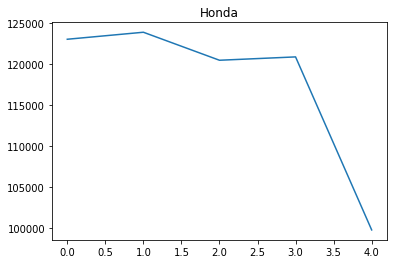

******************************
Hyundai
----------------------------------
2016: ['45,011', '53,009', '75,310', '62,213', '71,006', '67,511', '75,003', '70,518', '65,399', '61,304', '61,201', '60,572']
monthly_mean: 64004.75
['45,011', '53,009', '75,310', '62,213', '71,006', '67,511', '75,003', '70,518', '65,399', '61,304', '61,201', '60,572']
[45011, 53009, 75310, 62213, 71006, 67511, 75003, 70518, 65399, 61304, 61201, 60572]
standard deviation: 8874.202101136652
----------------------------------
2017: ['44,685', '51,438', '67,510', '61,651', '58,259', '52,894', '52,419', '52,507', '55,271', '51,224', '55,435', '61,646']
monthly_mean: 55411.583
['44,685', '51,438', '67,510', '61,651', '58,259', '52,894', '52,419', '52,507', '55,271', '51,224', '55,435', '61,646']
[44685, 51438, 67510, 61651, 58259, 52894, 52419, 52507, 55271, 51224, 55435, 61646]
standard deviation: 6063.401722380738
----------------------------------
2018: ['39,630', '44,732', '60,154', '55,035', '64,980', '63,256', 

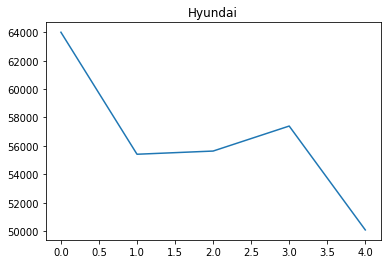

******************************
Infiniti
----------------------------------
2016: ['8,514', '10,371', '13,775', '10,432', '10,828', '11,058', '9,945', '10,439', '11,413', '11,208', '12,112', '18,198']
monthly_mean: 11524.417
['8,514', '10,371', '13,775', '10,432', '10,828', '11,058', '9,945', '10,439', '11,413', '11,208', '12,112', '18,198']
[8514, 10371, 13775, 10432, 10828, 11058, 9945, 10439, 11413, 11208, 12112, 18198]
standard deviation: 2449.8832424250654
----------------------------------
2017: ['11,558', '13,737', '18,266', '10,797', '12,514', '12,271', '10,840', '10,986', '12,745', '10,296', '13,026', '16,379']
monthly_mean: 12784.583
['11,558', '13,737', '18,266', '10,797', '12,514', '12,271', '10,840', '10,986', '12,745', '10,296', '13,026', '16,379']
[11558, 13737, 18266, 10797, 12514, 12271, 10840, 10986, 12745, 10296, 13026, 16379]
standard deviation: 2391.91891236583
----------------------------------
2018: ['10,635', '1,282', '17,432', '8,960', '11,625', '10,698', '9,747

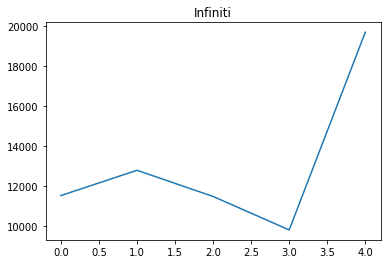

******************************
Jaguar
----------------------------------
2016: ['1,352', '1,512', '2,133', '1,087', '2,164', '2,743', '3,398', '3,298', '2,662', '3,219', '3,381', '4,294']
monthly_mean: 2603.583
['1,352', '1,512', '2,133', '1,087', '2,164', '2,743', '3,398', '3,298', '2,662', '3,219', '3,381', '4,294']
[1352, 1512, 2133, 1087, 2164, 2743, 3398, 3298, 2662, 3219, 3381, 4294]
standard deviation: 974.6564390811894
----------------------------------
2017: ['2,939', '3,484', '4,953', '3,230', '3,113', '2,946', '3,166', '3,101', '3,296', '2,891', '3,061', '3,414']
monthly_mean: 3299.5
['2,939', '3,484', '4,953', '3,230', '3,113', '2,946', '3,166', '3,101', '3,296', '2,891', '3,061', '3,414']
[2939, 3484, 4953, 3230, 3113, 2946, 3166, 3101, 3296, 2891, 3061, 3414]
standard deviation: 552.411161101123
----------------------------------
2018: ['2,604', '2,185', '3,260', '2,019', '2,366', '2,353', '1,880', '2,469', '2,040', '2,648', '3,197', '3,462']
monthly_mean: 2540.25
['2,604

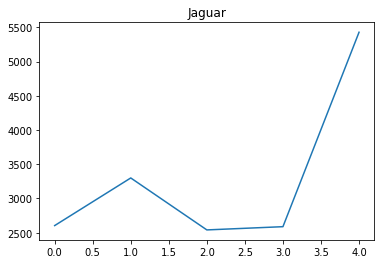

******************************
Jeep
----------------------------------
2016: ['59,032', '68,228', '82,337', '84,298', '90,545', '83,691', '79,246', '86,468', '76,331', '68,826', '67,285', '83,159']
monthly_mean: 77453.833
['59,032', '68,228', '82,337', '84,298', '90,545', '83,691', '79,246', '86,468', '76,331', '68,826', '67,285', '83,159']
[59032, 68228, 82337, 84298, 90545, 83691, 79246, 86468, 76331, 68826, 67285, 83159]
standard deviation: 9542.108560893592
----------------------------------
2017: ['58,415', '62,345', '67,983', '68,879', '75,516', '73,153', '69,351', '73,191', '73,409', '67,074', '66,001', '73,205']
monthly_mean: 69043.5
['58,415', '62,345', '67,983', '68,879', '75,516', '73,153', '69,351', '73,191', '73,409', '67,074', '66,001', '73,205']
[58415, 62345, 67983, 68879, 75516, 73153, 69351, 73191, 73409, 67074, 66001, 73205]
standard deviation: 5086.306062717457
----------------------------------
2018: ['59,703', '70,020', '98,382', '82,641', '97,287', '86,989', '79,

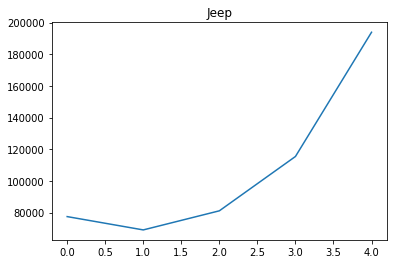

******************************
Kia
----------------------------------
2016: ['38,305', '49,737', '58,279', '56,508', '62,926', '62,572', '59,969', '54,248', '49,220', '48,977', '52,504', '54,353']
monthly_mean: 53966.5
['38,305', '49,737', '58,279', '56,508', '62,926', '62,572', '59,969', '54,248', '49,220', '48,977', '52,504', '54,353']
[38305, 49737, 58279, 56508, 62926, 62572, 59969, 54248, 49220, 48977, 52504, 54353]
standard deviation: 6930.678249637621
----------------------------------
2017: ['35,626', '42,673', '49,429', '53,358', '58,507', '56,143', '56,403', '53,323', '52,468', '44,397', '44,302', '43,039']
monthly_mean: 49139.0
['35,626', '42,673', '49,429', '53,358', '58,507', '56,143', '56,403', '53,323', '52,468', '44,397', '44,302', '43,039']
[35626, 42673, 49429, 53358, 58507, 56143, 56403, 53323, 52468, 44397, 44302, 43039]
standard deviation: 7029.52702404779
----------------------------------
2018: ['35,628', '40,672', '50,645', '50,585', '59,462', '56,571', '53,112'

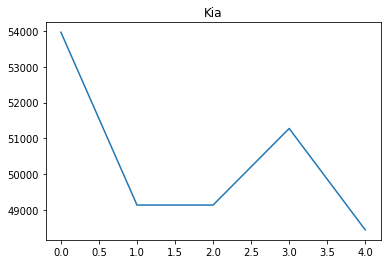

******************************
Lamborghini
----------------------------------
2016: ['66', '86', '86', '89', '94', '123', '88', '86', '77', '63', '76', '99']
monthly_mean: 86.083
['66', '86', '86', '89', '94', '123', '88', '86', '77', '63', '76', '99']
[66, 86, 86, 89, 94, 123, 88, 86, 77, 63, 76, 99]
standard deviation: 15.739113601778753
----------------------------------
2017: ['52', '71', '106', '72', '104', '102', '78', '73', '90', '112', '139', '96']
monthly_mean: 91.25
['52', '71', '106', '72', '104', '102', '78', '73', '90', '112', '139', '96']
[52, 71, 106, 72, 104, 102, 78, 73, 90, 112, 139, 96]
standard deviation: 23.471936822124803
----------------------------------
2018: ['60', '72', '122', '', '', '', '', '', '', '', '', '']
monthly_mean: 84.667
['60', '72', '122', '', '', '', '', '', '', '', '', '']
[60, 72, 122]
standard deviation: 32.88363321370273
array of monthly means
**************************************************
2020 sales: 84.667
2019 sales: 91.25
Z-Score: -0

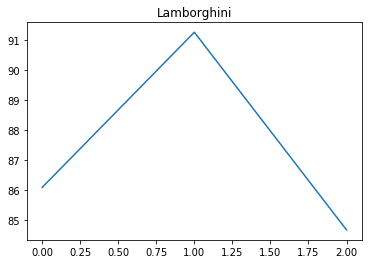

******************************
Land Rover
----------------------------------
2016: ['5,655', '6,417', '8,733', '5,188', '4,950', '5,705', '6,075', '6,031', '5,637', '5,532', '5,659', '8,279']
monthly_mean: 6155.083
['5,655', '6,417', '8,733', '5,188', '4,950', '5,705', '6,075', '6,031', '5,637', '5,532', '5,659', '8,279']
[5655, 6417, 8733, 5188, 4950, 5705, 6075, 6031, 5637, 5532, 5659, 8279]
standard deviation: 1167.3576579245762
----------------------------------
2017: ['6,163', '5,747', '7,965', '5,211', '4,993', '5,760', '5,915', '6,320', '6,407', '5,477', '6,801', '7,980']
monthly_mean: 6228.25
['6,163', '5,747', '7,965', '5,211', '4,993', '5,760', '5,915', '6,320', '6,407', '5,477', '6,801', '7,980']
[6163, 5747, 7965, 5211, 4993, 5760, 5915, 6320, 6407, 5477, 6801, 7980]
standard deviation: 959.7158788838592
----------------------------------
2018: ['6,446', '6,828', '10,972', '6,448', '7,103', '6,982', '6,209', '7,179', '6,966', '7,846', '8,547', '10,617']
monthly_mean: 7678.5

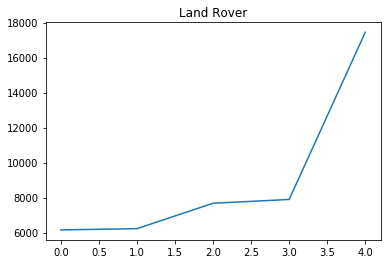

******************************
Lexus
----------------------------------
2016: ['20,933', '23,090', '30,198', '24,882', '26,682', '25,779', '27,890', '30,938', '25,801', '24,803', '29,050', '41,182']
monthly_mean: 27602.333
['20,933', '23,090', '30,198', '24,882', '26,682', '25,779', '27,890', '30,938', '25,801', '24,803', '29,050', '41,182']
[20933, 23090, 30198, 24882, 26682, 25779, 27890, 30938, 25801, 24803, 29050, 41182]
standard deviation: 5151.733994638616
----------------------------------
2017: ['15,572', '18,338', '27,935', '22,216', '25,401', '24,395', '28,902', '30,801', '26,196', '22,894', '27,118', '35,461']
monthly_mean: 25435.75
['15,572', '18,338', '27,935', '22,216', '25,401', '24,395', '28,902', '30,801', '26,196', '22,894', '27,118', '35,461']
[15572, 18338, 27935, 22216, 25401, 24395, 28902, 30801, 26196, 22894, 27118, 35461]
standard deviation: 5364.393554218916
----------------------------------
2018: ['17,914', '19,265', '27,032', '21,642', '25,391', '23,750', '2

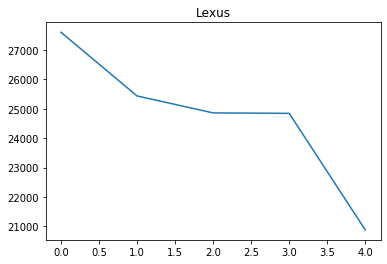

******************************
Lincoln
----------------------------------
2016: ['7,177', '8,039', '9,689', '9,776', '9,807', '8,809', '9,098', '9,234', '8,797', '9,069', '9,429', '12,791']
monthly_mean: 9309.583
['7,177', '8,039', '9,689', '9,776', '9,807', '8,809', '9,098', '9,234', '8,797', '9,069', '9,429', '12,791']
[7177, 8039, 9689, 9776, 9807, 8809, 9098, 9234, 8797, 9069, 9429, 12791]
standard deviation: 1332.3740573832406
----------------------------------
2017: ['8,785', '8,744', '9,554', '9,691', '10,288', '9,275', '8,875', '8,708', '8,802', '8,909', '8,909', '10,619']
monthly_mean: 9263.25
['8,785', '8,744', '9,554', '9,691', '10,288', '9,275', '8,875', '8,708', '8,802', '8,909', '8,909', '10,619']
[8785, 8744, 9554, 9691, 10288, 9275, 8875, 8708, 8802, 8909, 8909, 10619]
standard deviation: 645.0465980348735
----------------------------------
2018: ['6,410', '6,700', '9,352', '8,518', '9,755', '9,534', '7,898', '8,945', '8,168', '7,574', '9,207', '11,526']
monthly_mean: 8

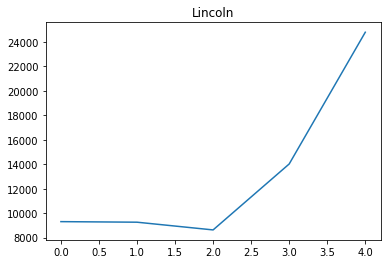

******************************
Maserati
----------------------------------
2016: ['525', '728', '997', '1,066', '945', '941', '811', '958', '1,185', '1,304', '1,380', '1,694']
monthly_mean: 1044.5
['525', '728', '997', '1,066', '945', '941', '811', '958', '1,185', '1,304', '1,380', '1,694']
[525, 728, 997, 1066, 945, 941, 811, 958, 1185, 1304, 1380, 1694]
standard deviation: 312.88670618786426
----------------------------------
2017: ['889', '1,087', '1,312', '1,265', '1,265', '900', '1,063', '1,103', '1,119', '1,140', '1,141', '1,427']
monthly_mean: 1142.583
['889', '1,087', '1,312', '1,265', '1,265', '900', '1,063', '1,103', '1,119', '1,140', '1,141', '1,427']
[889, 1087, 1312, 1265, 1265, 900, 1063, 1103, 1119, 1140, 1141, 1427]
standard deviation: 157.90472290324794
----------------------------------
2018: ['897', '931', '885', '', '', '', '', '', '', '', '', '']
monthly_mean: 904.333
['897', '931', '885', '', '', '', '', '', '', '', '', '']
[897, 931, 885]
standard deviation: 23.8

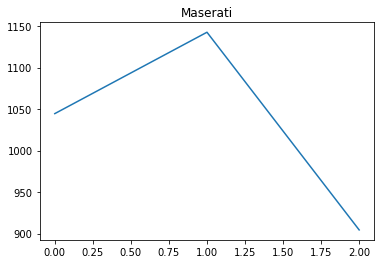

******************************
Mazda
----------------------------------
2016: ['19,703', '21,544', '23,396', '26,195', '28,328', '26,188', '27,915', '26,109', '24,889', '22,711', '22,041', '28,754']
monthly_mean: 24814.417
['19,703', '21,544', '23,396', '26,195', '28,328', '26,188', '27,915', '26,109', '24,889', '22,711', '22,041', '28,754']
[19703, 21544, 23396, 26195, 28328, 26188, 27915, 26109, 24889, 22711, 22041, 28754]
standard deviation: 2921.764176232427
----------------------------------
2017: ['21,698', '22,824', '24,549', '24,164', '26,047', '22,342', '27,089', '25,846', '25,738', '20,811', '21,469', '26,893']
monthly_mean: 24122.5
['21,698', '22,824', '24,549', '24,164', '26,047', '22,342', '27,089', '25,846', '25,738', '20,811', '21,469', '26,893']
[21698, 22824, 24549, 24164, 26047, 22342, 27089, 25846, 25738, 20811, 21469, 26893]
standard deviation: 2229.6552322153875
----------------------------------
2018: ['24,962', '25,731', '33,302', '23,056', '2,998', '26,893', '24

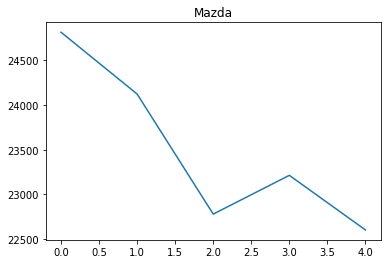

******************************
Mercedes-Benz
----------------------------------
2016: ['26,563', '25,210', '31,236', '31,825', '32,147', '31,558', '31,795', '31,556', '32,470', '31,383', '32,927', '35,871']
monthly_mean: 31211.75
['26,563', '25,210', '31,236', '31,825', '32,147', '31,558', '31,795', '31,556', '32,470', '31,383', '32,927', '35,871']
[26563, 25210, 31236, 31825, 32147, 31558, 31795, 31556, 32470, 31383, 32927, 35871]
standard deviation: 2791.627518947586
----------------------------------
2017: ['27,576', '27,035', '31,963', '29,125', '29,959', '32,102', '28,667', '28,954', '32,096', '31,401', '34,112', '39,250']
monthly_mean: 31020.0
['27,576', '27,035', '31,963', '29,125', '29,959', '32,102', '28,667', '28,954', '32,096', '31,401', '34,112', '39,250']
[27576, 27035, 31963, 29125, 29959, 32102, 28667, 28954, 32096, 31401, 34112, 39250]
standard deviation: 3342.8260499164476
----------------------------------
2018: ['27,498', '27,788', '31,374', '30,022', '30,077', '28,9

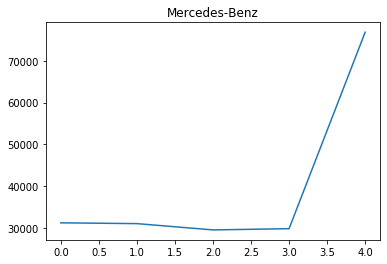

******************************
Mini
----------------------------------
2016: ['3,238', '2,839', '4,762', '4,796', '4,595', '4,914', '4,774', '4,969', '4,024', '3,954', '4,507', '4,658']
monthly_mean: 4335.833
['3,238', '2,839', '4,762', '4,796', '4,595', '4,914', '4,774', '4,969', '4,024', '3,954', '4,507', '4,658']
[3238, 2839, 4762, 4796, 4595, 4914, 4774, 4969, 4024, 3954, 4507, 4658]
standard deviation: 688.1846783496067
----------------------------------
2017: ['3,110', '2,154', '4,987', '3,481', '4,060', '4,410', '4,398', '4,448', '3,736', '3,669', '4,038', '4,611']
monthly_mean: 3925.167
['3,110', '2,154', '4,987', '3,481', '4,060', '4,410', '4,398', '4,448', '3,736', '3,669', '4,038', '4,611']
[3110, 2154, 4987, 3481, 4060, 4410, 4398, 4448, 3736, 3669, 4038, 4611]
standard deviation: 766.3950836496958
----------------------------------
2018: ['2,937', '3,065', '4,531', '3,731', '4,226', '4,146', '4,296', '3,800', '3,461', '3,166', '3,528', '2,797']
monthly_mean: 3640.333
['2,9

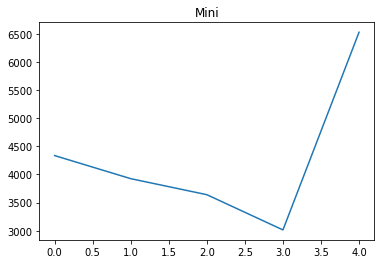

******************************
Nissan
----------------------------------
2016: ['97,220', '120,540', '149,784', '113,429', '122,668', '129,495', '122,530', '114,199', '116,384', '102,312', '103,024', '134,545']
monthly_mean: 118844.167
['97,220', '120,540', '149,784', '113,429', '122,668', '129,495', '122,530', '114,199', '116,384', '102,312', '103,024', '134,545']
[97220, 120540, 149784, 113429, 122668, 129495, 122530, 114199, 116384, 102312, 103024, 134545]
standard deviation: 14760.085734127288
----------------------------------
2017: ['100,761', '122,003', '150,566', '111,201', '124,957', '131,057', '117,455', '97,340', '127,187', '112,716', '122,959', '121,847']
monthly_mean: 120004.083
['100,761', '122,003', '150,566', '111,201', '124,957', '131,057', '117,455', '97,340', '127,187', '112,716', '122,959', '121,847']
[100761, 122003, 150566, 111201, 124957, 131057, 117455, 97340, 127187, 112716, 122959, 121847]
standard deviation: 14043.802013430133
--------------------------------

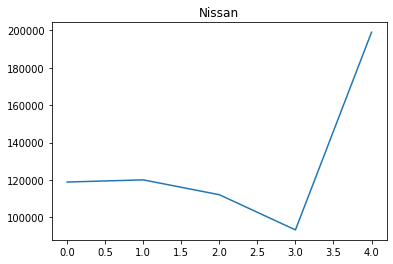

******************************
Porsche
----------------------------------
2016: ['4,354', '3,561', '4,323', '5,410', '4,578', '4,482', '3,878', '5,181', '4,479', '4,506', '5,513', '4,015']
monthly_mean: 4523.333
['4,354', '3,561', '4,323', '5,410', '4,578', '4,482', '3,878', '5,181', '4,479', '4,506', '5,513', '4,015']
[4354, 3561, 4323, 5410, 4578, 4482, 3878, 5181, 4479, 4506, 5513, 4015]
standard deviation: 593.5146981917945
----------------------------------
2017: ['4,159', '3,637', '4,479', '5,529', '4,805', '4,516', '3,901', '4,709', '5,059', '4,715', '5,555', '3,913']
monthly_mean: 4581.417
['4,159', '3,637', '4,479', '5,529', '4,805', '4,516', '3,901', '4,709', '5,059', '4,715', '5,555', '3,913']
[4159, 3637, 4479, 5529, 4805, 4516, 3901, 4709, 5059, 4715, 5555, 3913]
standard deviation: 614.4362469086207
----------------------------------
2018: ['4,816', '4,382', '4,756', '5,570', '5,005', '4,892', '4,020', '4,083', '5,102', '4,817', '5,673', '4,086']
monthly_mean: 4766.833
['

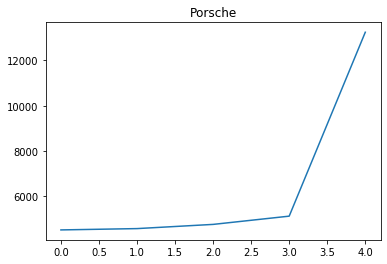

******************************
RAM Market Sales
----------------------------------
2016: ['33,021', '43,302', '49,990', '45,810', '43,613', '41,236', '44,069', '44,426', '51,866', '49,443', '42,511', '53,597']
monthly_mean: 45240.333
['33,021', '43,302', '49,990', '45,810', '43,613', '41,236', '44,069', '44,426', '51,866', '49,443', '42,511', '53,597']
[33021, 43302, 49990, 45810, 43613, 41236, 44069, 44426, 51866, 49443, 42511, 53597]
standard deviation: 5522.813517720398
----------------------------------
2017: ['38,045', '42,785', '51,749', '47,327', '51,044', '48,645', '44,090', '43,322', '51,686', '47,831', '4,039', '49,876']
monthly_mean: 43369.917
['38,045', '42,785', '51,749', '47,327', '51,044', '48,645', '44,090', '43,322', '51,686', '47,831', '4,039', '49,876']
[38045, 42785, 51749, 47327, 51044, 48645, 44090, 43322, 51686, 47831, 4039, 49876]
standard deviation: 13073.60949990708
----------------------------------
2018: ['32,039', '36,737', '44,878', '43,074', '51,884', '51

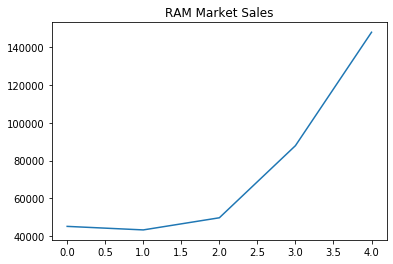

******************************
Range Rover
----------------------------------
2016: ['3,769', '4,045', '5,161', '3,306', '3,420', '3,700', '3,972', '4,033', '3,503', '3,677', '4,017', '6,240']
monthly_mean: 4070.25
['3,769', '4,045', '5,161', '3,306', '3,420', '3,700', '3,972', '4,033', '3,503', '3,677', '4,017', '6,240']
[3769, 4045, 5161, 3306, 3420, 3700, 3972, 4033, 3503, 3677, 4017, 6240]
standard deviation: 832.4783507968568
----------------------------------
2017: ['4,667', '4,542', '6,060', '4,252', '3,943', '3,901', '3,795', '4,296', '4,457', '3,992', '4,773', '5,476']
monthly_mean: 4512.833
['4,667', '4,542', '6,060', '4,252', '3,943', '3,901', '3,795', '4,296', '4,457', '3,992', '4,773', '5,476']
[4667, 4542, 6060, 4252, 3943, 3901, 3795, 4296, 4457, 3992, 4773, 5476]
standard deviation: 675.3779861991537
----------------------------------
2018: ['4,519', '5,308', '8,754', '5,078', '5,467', '5,281', '4,611', '5,522', '5,324', '5,749', '6,585', '8,068']
monthly_mean: 5855.5
[

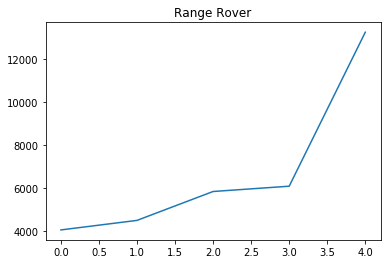

******************************
Rolls-Royce
----------------------------------
2016: ['70', '97', '113', '79', '73', '79', '75', '102', '78', '71', '81', '97']
monthly_mean: 84.583
['70', '97', '113', '79', '73', '79', '75', '102', '78', '71', '81', '97']
[70, 97, 113, 79, 73, 79, 75, 102, 78, 71, 81, 97]
standard deviation: 14.015954112973176
----------------------------------
2017: ['119', '126', '114', '121', '109', '111', '100', '114', '121', '104', '111', '123']
monthly_mean: 114.417
['119', '126', '114', '121', '109', '111', '100', '114', '121', '104', '111', '123']
[119, 126, 114, 121, 109, 111, 100, 114, 121, 104, 111, 123]
standard deviation: 7.890827048868294
----------------------------------
2018: ['110', '100', '116', '', '', '', '', '', '', '', '', '']
monthly_mean: 108.667
['110', '100', '116', '', '', '', '', '', '', '', '', '']
[110, 100, 116]
standard deviation: 8.082903768654761
array of monthly means
**************************************************
2020 sales: 108.

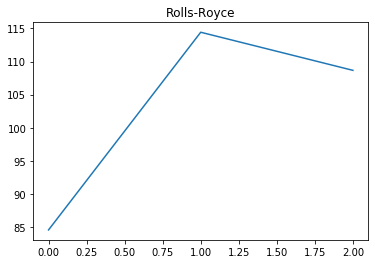

In [65]:
for brand_name, monthly_sales_figures in monthly_sales.items():
		print('******************************')
		print(brand_name)# + ': ' + str(monthly_sales_figures))

		array_of_monthly_means = []
		for year, monthly_sales_per_year in monthly_sales_figures.items():
			print('----------------------------------')
			print(str(year) + ': ' + str(monthly_sales_per_year))

			# KEEP THIS
			# Get the mean of each year, and store it in a database
			total_sales = 0
			number_of_sales = 0
			monthly_mean = 0
			monthly_sales_per_year_to_int = []
			check_for_empty_data = 0
			for sales in monthly_sales_per_year:
				# check whether the sales for that month are recorder
				if(sales != ''):
					# remove the ',' from the string, so we can convert it to an int
					sales = sales.replace(',', '')
					number_of_sales += 1
					# convert the sales from string to an int
					sales = int(sales)
					total_sales += sales
					check_for_empty_data += 1

					monthly_sales_per_year_to_int.append(sales)
			try:
				monthly_mean = total_sales / number_of_sales
			except ZeroDivisionError:
				print()
			monthly_mean = round(monthly_mean, 3)
			print("monthly_mean: " + str(monthly_mean))
			array_of_monthly_means.append(monthly_mean)

			# Get the std
			print(monthly_sales_per_year)
			print(monthly_sales_per_year_to_int)
			if check_for_empty_data >= 2:
				monthly_std_dev = statistics.stdev(monthly_sales_per_year_to_int)

			print('standard deviation: ' + str(monthly_std_dev))

		# Array of monthly means stores the mean monthly sales for each year.  
		print('array of monthly means')


		# Find how many standard deviations is the last month's sales away from
		# 	the mean of the year

		print('**************************************************')
		length = len(array_of_monthly_means)
		this_year = array_of_monthly_means[length - 1]
		last_year = array_of_monthly_means[length - 2] 
		change = this_year - last_year
		z_score = change / monthly_std_dev

		print('2020 sales: ' + str(this_year))
		print('2019 sales: ' + str(last_year))
		print('Z-Score: ' + str(z_score))

		if(z_score >= 1):
			print(brand_name + ' is improving. We should invest')
		
		else:
			print(brand_name + ' is not doing good enough')
		

		print('**************************************************')

		print(array_of_monthly_means)

		plt.plot(array_of_monthly_means)
		plt.title(brand_name)
		plt.show()

### As we can see, we should invest in Ford, Jeep, Lincoln, Audi, BMW, Infiniti, Jaguar, etc. However,
    1.BMW, Infinity, Jaguar, and other promising companies do not have stocks available in Investopedia.
    2.Lincoln and Ford are owned by Ford Motor Corporation
    3.Jeep and RAM is owned by Fiat Crystler Automobiles
**Hence, we invest in Ford, Fiat Crystler Automobiles**